# Untersuche wie sicher links / rechts klassifiziert wird
- Fazit: wenn nicht beide gleich, dann das mit mehr confidence nehmen
- UPDATE: 
    - Bug mit Transformationsmatrix hier nicht behoben (kann Matrix mit det=-1 geben)
    - Siehe auch verbesserte Version


In [3]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten

ogr.UseExceptions()

In [ ]:
tmpdir = "/media/riannek/minimax/gleis/temp_run24"

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A: 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43; Kreuzung: 44, 45;

key = list(interessant.keys())[0] 

filename = interessant[key]
filename = filename.split(".")[0] + ".ply"
print(key, filename)


if not os.path.exists(os.path.join(tmpdir, "candidates",filename)):
    raise FileNotFoundError(filename)

Einfach 4473900_5335875.ply


In [5]:
thresh_side_distance = 0.15   # 0.1 ist meist gut, aber in manchen Fällen zu wenig (z.B. Anfang Weiche)

intensity_threshold = 14500
downsample_radius = 0.45 # 0.4
neighborhood_radius = 0.5 # 0.5

min_points = 10
minimum_in_hood = 10
linearity_tresh = 0.98

gauge = 1.435
railhead_width = 0.067

In [6]:
runfolder = "/media/riannek/minimax/gleis/run24-2024-08-13"

import subprocess
#subprocess.Popen(["pyvistaviewer", os.path.join(runfolder, filename.split(".")[0] + ".copc.laz")])

## Datei incl. margin aus Nachbarkacheln

In [7]:
gpkg = ogr.Open(os.path.join(tmpdir, "temp.gpkg"))
layer = gpkg.GetLayerByName("tiles")

In [8]:
def extend_bbox(bbox, margin=2):
    # MinX, MaxX, MinY, MaxY
    return (bbox[0] - margin, bbox[1] + margin, bbox[2] - margin, bbox[3] + margin)

def get_bbox_polygon(bbox):  
    ring = ogr.Geometry(ogr.wkbLinearRing)      
    ring.AddPoint_2D(bbox[0], bbox[2])  # MinX, MinY
    ring.AddPoint_2D(bbox[1], bbox[2])  # MaxX, MinY
    ring.AddPoint_2D(bbox[1], bbox[3])  # MaxX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[3])  # MinX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[2])  # Close ring
    geom = ogr.Geometry(ogr.wkbPolygon)
    geom.AddGeometry(ring)
    return geom

In [9]:
filter = f"filename = '{filename}'"
layer.SetAttributeFilter(filter)
feature = layer.GetNextFeature()
layer.SetAttributeFilter(None)
bbox = feature.GetGeometryRef().GetEnvelope()
extended = extend_bbox(bbox, margin=2)
bbox_geom = get_bbox_polygon(extended)
layer.SetSpatialFilter(bbox_geom)
tiles = [f.GetField("filename") for f in layer]
layer.SetSpatialFilter(None) 

print(tiles) 

['4473925_5335850.ply', '4473875_5335900.ply', '4473875_5335850.ply', '4473900_5335850.ply', '4473875_5335875.ply', '4473900_5335900.ply', '4473900_5335875.ply']


In [10]:
bbox # MinX, MaxX, MinY, MaxY

(4473900.0, 4473925.0, 5335875.0, 5335900.0)

In [11]:
del gpkg

In [12]:
bounds = f"([{extended[0]}, {extended[1]}], [{extended[2]}, {extended[3]}])" 
bounds

'([4473898.0, 4473927.0], [5335873.0, 5335902.0])'

In [ ]:
readers = [pdal.Reader(os.path.join(tmpdir,"candidates", tile)) for tile in tiles]
pipeline = pdal.Pipeline(readers) | pdal.Filter.merge() | pdal.Filter.crop(bounds=bounds)
pipeline.execute()
points = pipeline.arrays[0]
points.shape 

(107650,)

## Seed Points

In [14]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(57235,)

In [15]:
bounds = f"([{bbox[0]}, {bbox[1]}], [{bbox[2]}, {bbox[3]}])" 
bounds

'([4473900.0, 4473925.0], [5335875.0, 5335900.0])'

In [16]:
# Downsample with poisson sampling (only original bbox)

downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

266

## KD Tree

In [17]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()

In [18]:
offset = xyz.mean(axis=0).round() 
xyz -= offset
xyz_seed -= offset

In [19]:
tree = KDTree(xyz)  

# indices: ndarray (dtype object) with a list of indices for each seed point
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)

## Funktionen

In [20]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

def linearity(eigenvals):
    """Calculate the linearity of a point cloud"""
    return (eigenvals[0] - eigenvals[1]) / eigenvals[0]

def verticality(eigenvects):
    """Calculate the verticality of a point cloud
    
    1 minus z of the third eigenvector
    """
    return 1 - eigenvects.T[2][2]

In [21]:
def dbscan_stretchz(xyz, min_points=10, stretch=1.5):

    pointcount = xyz.shape[0]
    if pointcount <= min_points:
        return np.ones(pointcount, dtype=np.int8) * -1
    
    eps = 50 / pointcount
    eps = max(eps, 0.06)
    
    xyz = xyz.copy()
    xyz[:, 2] *= stretch
    hood_pcd = o3d.geometry.PointCloud()
    hood_pcd.points = o3d.utility.Vector3dVector(xyz) 
    # eps is min distance between clusters
    labels = np.array(hood_pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))
    return labels



In [22]:
def plot_cluster_line(cluster, eigenvects, stretch=0.2):
    start = cluster.mean(axis=0)
    vector = eigenvects.T[0] * stretch
    end = start + vector
    line = pv.Line(start, end)

    return line

In [23]:
def plot_first_eigenvec(point, eigenvects, color=[1, 0, 0], stretch=1):
    """Plot a vector as a line"""
    vector = eigenvects.T[0] * stretch
    end = point + vector
    line = o3d.geometry.LineSet()
    line.points = o3d.utility.Vector3dVector([point, end])
    line.lines = o3d.utility.Vector2iVector([[0, 1]])
    line.colors = o3d.utility.Vector3dVector([color])
    return line

In [24]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [25]:
def to_color(skalar, cmap=plt.cm.plasma):
    return cmap(skalar)[:3]

In [26]:
def cluster_is_on_top(cluster, clustercenter, points):
    """Check that there are no points above the cluster center"""
    x_min, x_max = clustercenter[0] - 0.05, clustercenter[0] + 0.05
    y_min, y_max = clustercenter[1] - 0.05, clustercenter[1] + 0.05
    z_min = cluster[:,2].max()

    mask = ((points[:, 0] > x_min) & 
        (points[:, 0] < x_max) & 
        (points[:, 1] > y_min) & 
        (points[:, 1] < y_max) & 
        (points[:, 2] > z_min))
    
    
    return points[mask].shape[0] == 0

In [27]:
def cluster_generator(points, min_points):
    if points.shape[0] < min_points:
        return
    
    labels = dbscan_stretchz(points, min_points=min_points, stretch=4)

    # if len(labels) == 0:
    #     return
    
    max_label = labels.max()
    
    for label in range(max_label + 1):
        cluster = points[labels == label]
        if cluster.shape[0] < min_points:
            # Somehow this happens, must be a bug in open3d
            continue

        eigenvals, eigenvects = pca(cluster)
        cluster_linearity = linearity(eigenvals)


        if not ((cluster_linearity > linearity_tresh) and (eigenvals[0] > 0.04)):
            # Cluster not linear or too short
            continue

        clustercenter = cluster.mean(axis=0)

        # Make sure there are no points above the cluster
        # (exclude clusters at the base of the track profile)
        if not cluster_is_on_top(cluster, clustercenter, points):
            continue
        

        yield cluster, clustercenter, eigenvals, eigenvects


def check_cluster_for_railpair(clustercenter, eigenvects, pointcloud, tree, gauge, min_points):

    # Check for rail pair
    sidevector = np.cross(eigenvects[:,0], np.array([0, 0, 1])) * (gauge + 0.07) # Add railtop width to gauge
    bothsides = np.array([clustercenter + sidevector, clustercenter - sidevector])

    indices_bothsides = tree.query_ball_point(bothsides, r=neighborhood_radius)
    
    # Linear cluster that is closest to one of the estimated side points (ignoring z)
    # but must me within r = 15 cm and almost parallel

    closest_cluster_distance = np.inf
    closest_cluster = None
    closest_cluster_center = None
    
    for j, side in enumerate(indices_bothsides):
        for sidecluster, sideclustercenter, _, eigenvects_side in cluster_generator(pointcloud[side], min_points):
            
            # Check distance
            sidecluster_distance = np.linalg.norm(sideclustercenter[:2] - bothsides[j][:2]) # only xy
            if sidecluster_distance < thresh_side_distance and sidecluster_distance < closest_cluster_distance:
                # Check if parallel
                cos_angle = np.abs(np.dot(eigenvects[:,0], eigenvects_side[:,0]))
                if cos_angle > 0.9:  
                    closest_cluster = sidecluster
                    closest_cluster_distance = sidecluster_distance
                    closest_cluster_center = sideclustercenter

    return closest_cluster, closest_cluster_center

In [28]:
def is_left_side(cluster):
    """Check if the transformed cluster is on the left side of the track"""

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    probab = np.abs(left_count - right_count) / (left_count + right_count)

    return left_count < right_count, probab 

In [ ]:
# VERBESSERT IN VERSION 2
def checkside(cluster, transformmatrix):
    """Verwendet im experementellen Modus"""
    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()
    if max_z < 0.03:
        return 0, 1

    isleft, probab = is_left_side(transformed)
    if isleft:
        return 1, probab
    else:
        return -1, probab



In [30]:
def representive_point_2(cluster, transformmatrix, percentile=95, lowerpercentile=70, railhead_width=0.067,z_thresh=-0.01):
    """Version 2

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()


    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > z_thresh][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if is_left_side(transformed):
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], percentile)

    
    transformed_representive = np.array([center_x, 0, center_z])
    return transformed_representive @ transformmatrix.T + center

In [31]:
def pair_generator():

    for i in range(seed_point_count):
        for cluster, clustercenter, eigenvals, eigenvects in cluster_generator(xyz[indices[i]], min_points=min_points):
            cluster_other, center_other = check_cluster_for_railpair(clustercenter, eigenvects, xyz, tree, gauge, min_points)
            if cluster_other is not None:
                yield cluster, clustercenter, cluster_other, center_other, eigenvects 

In [ ]:
# Alte Version, Bug nicht behoben

def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(eigenvects.T[0], sidevector_perpendicular) 

    if normal[2] < 0:
        # print("Switched normal")
        normal *= -1

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    return matrix

## Alle

In [56]:
with_lines = True

In [57]:
def pv_bbox(plotter, bbox, offset=None):
    points = np.array(
        [[bbox[0], bbox[2], 0],
        [bbox[1], bbox[2], 0],
        [bbox[1], bbox[3], 0],
        [bbox[0], bbox[3], 0],
        [bbox[0], bbox[2], 0]]
    )
    if offset is not None:
        points[:,:2] -= offset[:2]
    lines = np.array([5, 0, 1, 2, 3, 0])
    box = pv.PolyData(points)
    box.lines = lines
    plotter.add_mesh(box, color="black", line_width=2, point_size=0, render_points_as_spheres=False)

In [58]:
# Ursprüngliche Version, nachträglich verbessert Version 2

start = time.time()

lines = []
center_points = []
samesides = []
probabs = []
sides = []

for cluster, clustercenter, cluster_other, center_other, eigenvects in pair_generator():
    transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, center_other, eigenvects)
    side_this, probab_this = checkside(cluster, transformmatrix)
    side_other, probab_other = checkside(cluster_other, transformmatrix)

    sameside = int(side_this == side_other)

    lines.append(pv.Line(clustercenter, center_other))
    center_points.append(clustercenter)
    center_points.append(center_other)
    sides.append(side_this)
    sides.append(side_other)
    probabs.append(probab_this)
    probabs.append(probab_other)
    samesides.append(sameside)
    samesides.append(sameside)


print(f"Time: {time.time() - start:.2f} s")

Time: 0.71 s


In [59]:
pv_all = pv.PolyData(xyz)

In [60]:
center_points = np.array(center_points)
pv_centerpoints = pv.PolyData(center_points)
pv_centerpoints["side"] = np.array(sides)
pv_centerpoints["sameside"] = np.array(samesides)
pv_centerpoints["probab"] = np.array(probabs)

pv_centerpoints["bla"] = (pv_centerpoints["sameside"] - 1)* pv_centerpoints["probab"] 


p = pv.Plotter()

if with_lines:
    # Add lines (SLOW)
    # for color, line in zip(side_distances, lines):
    #     p.add_mesh(line, scalars=color, cmap='plasma')
    for line in lines:
        p.add_mesh(line, color="red")

p.add_mesh(pv_all, color='gray', point_size=1)
p.add_mesh(pv_centerpoints, scalars="bla", point_size=5, cmap="viridis")

pv_bbox(p, bbox, offset)

# labels = [str(i) for i in range(len(center_points))]
# p.add_point_labels(pv_centerpoints, labels, point_color="black", font_size=12)

p.show()



Widget(value='<iframe src="http://localhost:34601/index.html?ui=P_0x7f6730b1cfa0_2&reconnect=auto" class="pyvi…

In [61]:
prob = np.array(probabs)
prob = prob.reshape(-1, 2)

In [62]:
sameside = np.array(samesides)
sameside = sameside.reshape(-1, 2)

In [63]:
prob.shape, sameside.shape

((175, 2), (175, 2))

Sameside ist 1 (True) oder 0 (False)

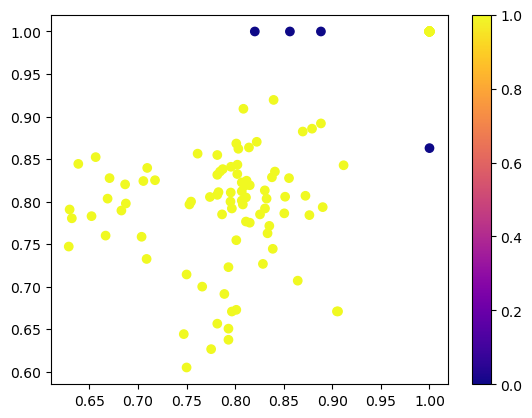

In [64]:
fig, ax = plt.subplots()
ax.scatter(prob[:,0], prob[:,1], c=sameside[:,0], cmap="plasma")
# colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax)

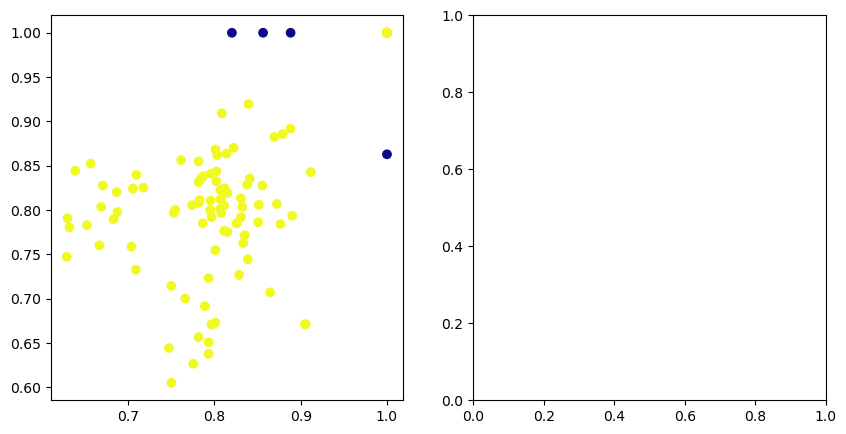

In [66]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(prob[:,0], prob[:,1], c=sameside[:,0], cmap="plasma")